# Training: Neuronales Netzwerk mit dem Tuner von Keras

In diesem Notebook wird ein neuronales Netzwerk mit dem [Tuner von Keras](https://keras.io/keras_tuner/) trainiert. Der Tuner von Keras ist ein Tool, das automatisiert die Hyperparameter eines Modells optimiert. In diesem Fall wird der Tuner verwendet, um die Batch Size als Hyperparameter zu optimieren. Dabei ist das Ziel den Validierungsfehler zu minimieren.

Zunächst werden die notwendigen Bibliotheken importiert.

In [77]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import os
import keras_tuner as kt
import wandb
import seaborn as sns

from tensorflow.keras import layers, Model, optimizers, losses, callbacks
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from wandb.integration.keras import WandbMetricsLogger
from sklearn.metrics import confusion_matrix

Anschließend werden die Daten eingelesen und nutzbar gemacht.

In [78]:
train = pd.read_csv('../data/preprocessed/train_data.csv')
test = pd.read_csv('../data/preprocessed/test_data.csv')
val = pd.read_csv('../data/preprocessed/val_data.csv')

In [79]:
X_train = train.drop("Is high risk", axis=1)
Y_train = train["Is high risk"]

X_test = test.drop("Is high risk", axis=1)
Y_test = test["Is high risk"]

X_val = val.drop("Is high risk", axis=1)
Y_val = val["Is high risk"]

Nun wird der `model_builder`definiert. Dieser wird vom Tuner verwendet, um das Modell zu erstellen. In diesem Fall wird ein einfaches neuronales Netzwerk mit vier hidden Layern und einer Output Layer erstellt. Die hidden Layer haben jeweils 64 Neuronen und die ReLU Aktivierungsfunktion. Die Output Layer hat ein Neuron und die Sigmoid Aktivierungsfunktion.

In [80]:
def model_builder(hp):
  x = layers.Input(shape=(X_train.shape[1],))
  h = layers.Dense(64, activation='relu')(x)
  h = layers.Dense(64, activation='relu')(h)
  h = layers.Dense(64, activation='relu')(h)
  h = layers.Dense(64, activation='relu')(h)

  y = layers.Dense(1, activation='sigmoid')(h)

  model = Model(inputs=x, outputs=y)

  hp_batch_size = hp.Choice('batch_size', values=[32, 64, 128, 256, 512])
  
  optimizer = optimizers.Adam(learning_rate=0.001, 
                            beta_1=0.9, 
                            beta_2=0.999, 
                            amsgrad=True)

  model.compile(optimizer=optimizer,
                loss=losses.BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])

  return model

In [81]:
# Delete Folder optimization if it exists
if os.path.exists('optimization'):
    os.system('rm -rf optimization')

Nun wird der Tuner erstellt.

In [82]:
tuner = kt.RandomSearch(model_builder,
                     objective='val_loss',
                     max_trials=20,
                     executions_per_trial=1,
                     directory='optimization',
                     project_name='ml',
                     overwrite=True)

Nun wird die Funktion `run_tuning` definiert, welche den zuvor definierten Tuner nutzt, um die Batch Size zu optimieren.

In [83]:
def run_tuning(tuner, X_train, Y_train, X_val, Y_val):
    tuner.search(X_train, Y_train, 
                 epochs=10, 
                 validation_data=(X_val, Y_val),
                 )

    # Get the optimal hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    optimal_batch_size = best_hps.get('batch_size')

    print(f"""
    The hyperparameter search is complete. The optimal batch size is {optimal_batch_size}.
    """)

    return best_hps

Nun wird ein Tuning gestartet und die Ergebnisse werden in `best_hps` gespeichert.

In [84]:
best_hps = run_tuning(tuner, X_train, Y_train, X_val, Y_val)

Trial 5 Complete [00h 00m 13s]
val_loss: 0.9197248816490173

Best val_loss So Far: 0.7934117913246155
Total elapsed time: 00h 01m 06s

    The hyperparameter search is complete. The optimal batch size is 32.
    


Nun wird basierend auf den Ergebnissen ein neues Modell erstellt.

In [85]:
model = tuner.hypermodel.build(best_hps)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 47)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,617 (61.00 KB)

 Trainable params: 15,617 (61.00 KB)

 Non-trainable params: 0 (0.00 B)

Es wird Early Stopping verwendet, um das Training zu stoppen, wenn der Validierungsfehler nicht mehr sinkt.

In [86]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    min_delta=0.001,     # Minimum change to qualify as an improvement
    patience=100,         # How many epochs to wait after last time val loss improved
    verbose=1,
    mode='min',          # The training will stop when the quantity monitored has stopped decreasing
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity.
)

Weights and Biases wird verwendet, um das Training zu überwachen.

In [87]:
# wandb.login()

Die Batch Size wird auf den besten Wert gesetzt.

In [88]:
batch_size = best_hps.get('batch_size')
epochs = 1000

Es wird ein neuer run in Weights and Biases um das Training zu überwachen.

In [89]:
run = wandb.init(project='ml_assignment_keras', 
                 config={
                     "learning_rate": 0.001, 
                     "epochs": epochs,
                     "batch_size": batch_size,
                     "loss_function": "BinaryCrossentropy",
                     "architecture": "Dense(64, relu) -> Dense(64, relu) -> Dense(64, relu) -> Dense(64, relu) -> Dense(1, sigmoid)",
                     "dataset": "Credit Card",
                     "optimizer": "Adam"})

Das Modell wird trainiert und abgespeichert und das Training wird in Weights and Biases überwacht.

In [90]:
history = model.fit(X_train, 
                    Y_train, 
                    batch_size=batch_size,
                    validation_data=(X_val, Y_val),
                    callbacks=[WandbMetricsLogger(), early_stopping],
                    epochs=epochs)

if not os.path.exists('../models'):
    os.makedirs('../models')

model.save('../models/model_keras_tuning.h5')

Epoch 1/1000
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 2s 800us/step - accuracy: 0.5113 - loss: 136.7083 - val_accuracy: 0.4983 - val_loss: 19.0843
Epoch 2/1000
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 1s 748us/step - accuracy: 0.5282 - loss: 8.0832 - val_accuracy: 0.5057 - val_loss: 12.5630
Epoch 3/1000
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 1s 727us/step - accuracy: 0.5254 - loss: 3.7590 - val_accuracy: 0.5073 - val_loss: 3.0365
Epoch 4/1000
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 1s 738us/step - accuracy: 0.5326 - loss: 1.9338 - val_accuracy: 0.5450 - val_loss: 1.2910
Epoch 5/1000
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 1s 733us/step - accuracy: 0.5401 - loss: 1.1512 - val_accuracy: 0.5140 - val_loss: 1.5234
Epoch 6/1000
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 1s 625us/step - accuracy: 0.5386 - loss: 1.0814 - val_accuracy: 0.5143 - val_loss: 0.9758
Epoch 7/1000
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 1s 580us/step - accuracy: 0.5492 - loss: 0.8968 - val_accuracy: 0.4993 - val_loss: 1.2826
Epoch 8/1000
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 1s 563us/step 

In [91]:
wandb.finish()

epoch/accuracy,▁▂▃▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/loss,█▃▃▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▁▃▃▄▅▄▃▄▆▆▃▆▇▇▇▇▅▇█▇▇▇▇▇█▇▆▆█▆▇█▇▇███▇▆
epoch/val_loss,█▄▄▄▃▃▃▄▃▂▃▅▃▂▂▁▂▂▂▁▂▂▂▁▂▁▂▃▃▂▂▂▂▂▃▂▂▁▃▃
epoch/accuracy,0.84546
epoch/epoch,453
epoch/loss,0.33804
epoch/val_accuracy,0.83966
epoch/val_loss,0.51704


Der Trainingsprozess wird in Bezug auf Accuracy und Loss visualisiert.

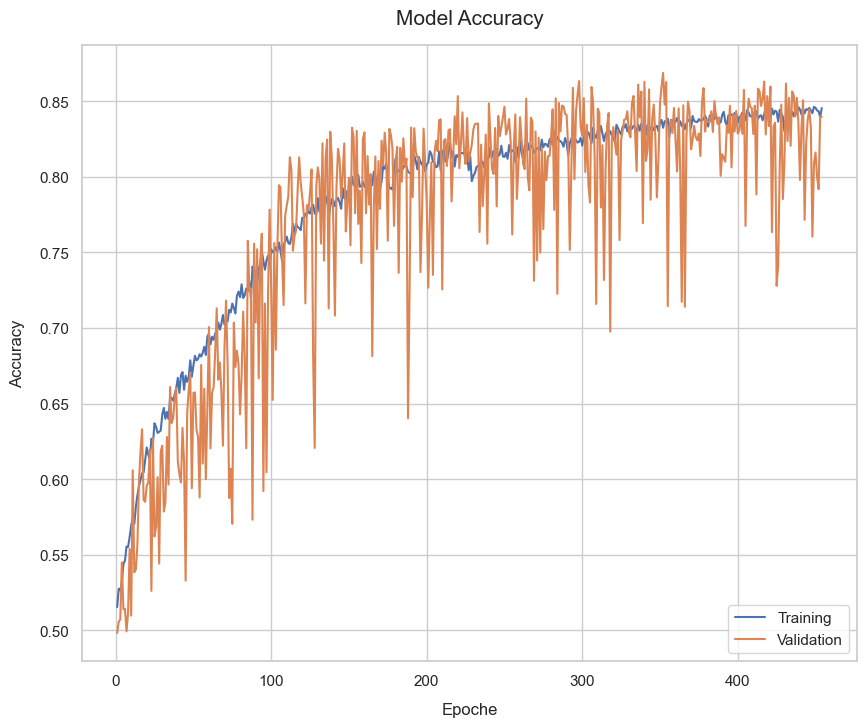

In [92]:
# Print the model training history for accuracy
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(10,8))
plt.plot(epochs, accuracy)
plt.plot(epochs, val_accuracy)
plt.title('Model Accuracy', fontsize=15, pad=15)
plt.ylabel('Accuracy', fontsize=12, labelpad=10)
plt.xlabel('Epoche', fontsize=12, labelpad=10)
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

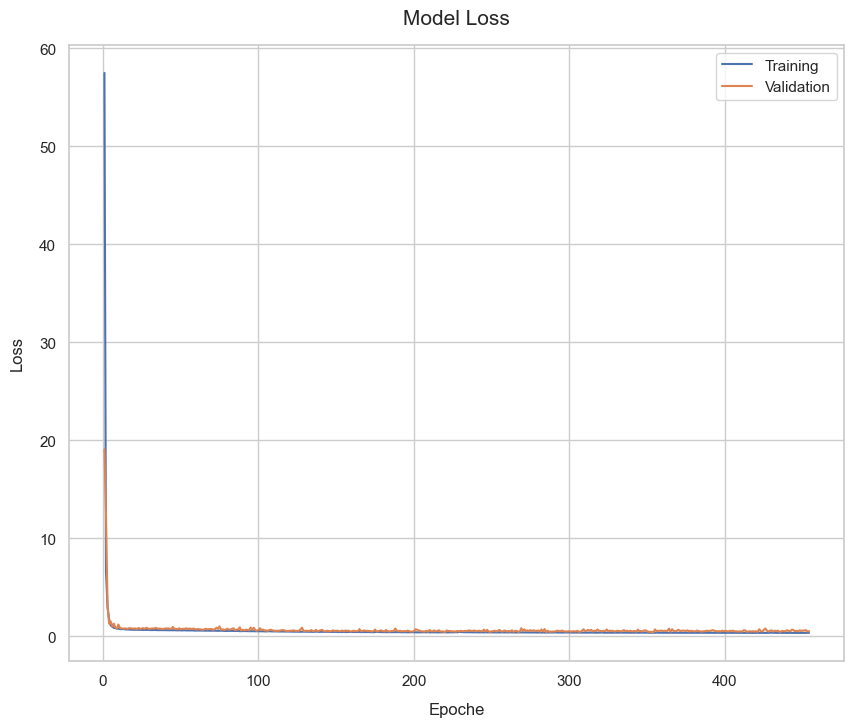

In [93]:
# print the model training history for loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10,8))
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Model Loss', fontsize=15, pad=15)
plt.ylabel('Loss', fontsize=12, labelpad=10)
plt.xlabel('Epoche', fontsize=12, labelpad=10)
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

Das Modell wird für die drei zur verfügung stehenden Datensätze evaluiert. Die ergebnisse weichen nicht zu stark voneinenader ab.

In [94]:
model.evaluate(X_test, Y_test)

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - accuracy: 0.8221 - loss: 0.4262


[0.42668822407722473, 0.8217224478721619]

In [95]:
model.evaluate(X_val, Y_val)

336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step - accuracy: 0.8450 - loss: 0.3818


[0.397469162940979, 0.8626301884651184]

In [96]:
model.evaluate(X_train, Y_train)

1568/1568 ━━━━━━━━━━━━━━━━━━━━ 1s 321us/step - accuracy: 0.8350 - loss: 0.3541


[0.3228357136249542, 0.8506656289100647]

Es wird eine Confusion Matrix für den Testdatensatz erstellt.

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step


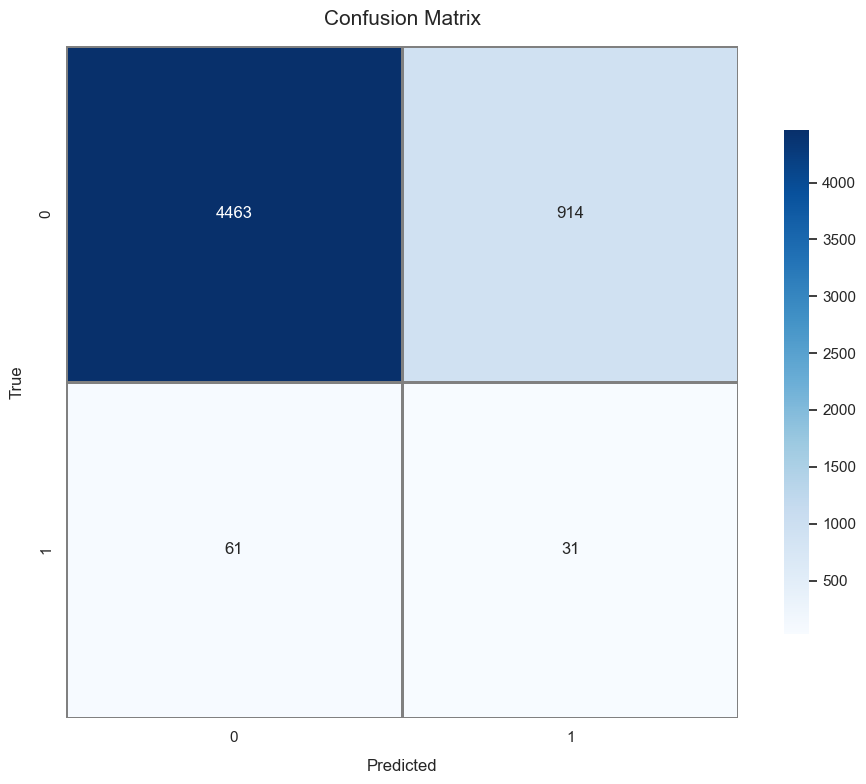

In [97]:
# make a confusion matrix for the test data
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

cm = confusion_matrix(Y_test, y_pred)

# Set the style of the heatmap
sns.set_theme(style="whitegrid")

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', square=True, cmap='Blues', cbar_kws={'shrink': 0.75}, linewidths=1, linecolor='grey')

# Add labels
plt.xlabel('Predicted', fontsize=12, labelpad=10)
plt.ylabel('True', fontsize=12, labelpad=10)
plt.title('Confusion Matrix', fontsize=15, pad=15)

# Improve the layout
plt.tight_layout()

# Display the plot
plt.show()